In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torch.utils.tensorboard import SummaryWriter
from torchvision import datasets
import numpy as np
from torch.optim.lr_scheduler import StepLR

In [2]:
transform_train = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),  # Случайное горизонтальное отражение
    transforms.RandomRotation(30),
    transforms.ToTensor(),  # Преобразуем изображение в тензор
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Нормализация (среднее и std для ImageNet)
])

validation_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], # RGB mean & std estied on ImageNet
                         [0.229, 0.224, 0.225])
])

transform_test = transforms.Compose([
    transforms.Resize((256)),
    transforms.CenterCrop(224),
    transforms.ToTensor(),                  # Преобразуем изображения в тензоры
    transforms.Normalize(mean= [0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Нормализация
])

# Загрузка тренировочного и тестового датасетов
train_dataset = datasets.Flowers102(root='data', split='train', download=True, transform= transform_train)
validation_dataset = datasets.Flowers102(root='data', split='val', download=True, transform= validation_transforms)
test_dataset = datasets.Flowers102(root='data', split='test', download=True, transform= transform_test)

In [3]:
print(f"Train dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(validation_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")

Train dataset size: 1020
Validation dataset size: 1020
Test dataset size: 6149


In [4]:
train_set = test_dataset
combined_train_set = torch.utils.data.ConcatDataset([train_dataset, validation_dataset])

In [5]:
txt_file = open('flowers102_label_names.txt','r').read().splitlines()
class_names = [x.replace('"','').replace("'", '') for x in txt_file]

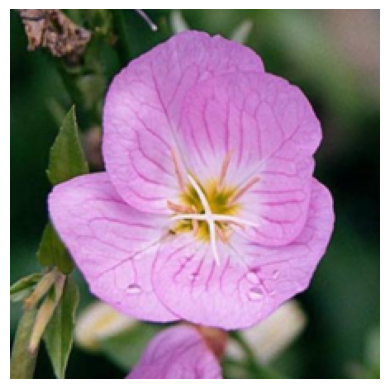

In [6]:
import matplotlib.pyplot as plt

def imshow(img, mean, std):
    # Декодируем изображение обратно с учетом нормализации
    for c in range(img.shape[0]):  # Для каждого канала
        img[c] = img[c] * std[c] + mean[c]  # Обратная нормализация для каждого канала

    img = np.clip(img, 0, 1)  # Ограничиваем значения пикселей в пределах [0, 1]
    plt.imshow(img.transpose((1, 2, 0)))  # Переход от (C, H, W) к (H, W, C)
    plt.axis('off')  # Отключаем оси
    plt.show()

# Извлекаем изображение из набора данных
img_tensor = train_set[0][0]  # Получаем первое изображение (и его метку)

# Нормализационные параметры для обратной нормализации
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

# Визуализируем изображение
imshow(img_tensor.numpy(), mean, std)

In [7]:
train_dataloader = DataLoader(train_set, batch_size=64, shuffle=True)
val_loader = DataLoader(validation_dataset, batch_size=64, shuffle=False)
test_dataloader = DataLoader(combined_train_set, batch_size=64,shuffle=True)

In [8]:
!pip install torchinfo

In [9]:
class ImprovedCNN(nn.Module):
    def __init__(self):
        super(ImprovedCNN, self).__init__()
        
        # Слои свёрточной нейронной сети с Batch Normalization
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.flatten = nn.Flatten()
        
        # Полносвязный слой с Dropout
        self.fc1 = nn.Linear(in_features=128 * 28 * 28, out_features=512)
        self.fc2 = nn.Linear(in_features=512, out_features=102)

        self.dropout = nn.Dropout(p=0.5)
        
    def forward(self, x):
        # Прямой проход через сеть с Batch Normalization и Dropout
        x = F.relu(self.bn1(self.conv1(x)))  # Применяем BN и ReLU
        x = self.pool1(x)

        x = F.relu(self.bn2(self.conv2(x)))  # Применяем BN и ReLU
        x = self.pool2(x)

        x = F.relu(self.bn3(self.conv3(x)))  # Применяем BN и ReLU
        x = self.pool3(x)

        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# Создание модели
model = ImprovedCNN()

print(model)

ImprovedCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=100352, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=102, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)


In [10]:
from torchinfo import summary
summary(ImprovedCNN(), input_size=(30,3, 224, 224))

Layer (type:depth-idx)                   Output Shape              Param #
ImprovedCNN                              [30, 102]                 --
├─Conv2d: 1-1                            [30, 32, 224, 224]        896
├─BatchNorm2d: 1-2                       [30, 32, 224, 224]        64
├─MaxPool2d: 1-3                         [30, 32, 112, 112]        --
├─Conv2d: 1-4                            [30, 64, 112, 112]        18,496
├─BatchNorm2d: 1-5                       [30, 64, 112, 112]        128
├─MaxPool2d: 1-6                         [30, 64, 56, 56]          --
├─Conv2d: 1-7                            [30, 128, 56, 56]         73,856
├─BatchNorm2d: 1-8                       [30, 128, 56, 56]         256
├─MaxPool2d: 1-9                         [30, 128, 28, 28]         --
├─Flatten: 1-10                          [30, 100352]              --
├─Linear: 1-11                           [30, 512]                 51,380,736
├─Dropout: 1-12                          [30, 512]                

In [11]:
# Создаём модель
model = ImprovedCNN()

# Убираем использование GPU (если доступен)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Оптимизатор
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)  # SGD с моментумом

# Использование StepLR для уменьшения скорости обучения
scheduler = StepLR(optimizer, step_size=5, gamma=0.5)

# Функция потерь для многоклассовой классификации
criterion = nn.CrossEntropyLoss()

# Логирование с использованием TensorBoard
writer = SummaryWriter(log_dir='runs/flower_classification')  # Создаём директорию для TensorBoard


In [12]:
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

num_epochs = 10  # Количество эпо

for epoch in range(num_epochs):
    model.train()
    
    running_loss = 0.0
    correct_preds = 0
    total_preds = 0
    
    for inputs, labels in train_dataloader:  # train_loader — это твой DataLoader для тренировочных данных
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()  # Обнуляем градиенты

        outputs = model(inputs)  # Прямой проход
        loss = criterion(outputs, labels)  # Вычисляем потерю

        loss.backward()  # Обратное распространение
        optimizer.step()  # Шаг оптимизации

        running_loss += loss.item() #* inputs.size(0)  # Накопление потерь
        _, predicted = torch.max(outputs, 1)  # Выбираем класс с максимальной вероятностью
        correct_preds += (predicted == labels).sum().item()
        total_preds += labels.size(0)

    # Логирование потерь и точности в TensorBoard
    epoch_loss = running_loss / len(train_dataloader.dataset)
    epoch_accuracy = correct_preds / total_preds
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_accuracy)

    writer.add_scalar('Training Loss', epoch_loss, epoch)
    writer.add_scalar('Training Accuracy', epoch_accuracy, epoch)

    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.4f}')

 # Шаг валидации
    model.eval()  # Переключаем модель в режим оценки (выключаем Dropout и BatchNorm, если есть)
    
    val_loss = 0.0
    correct_preds_val = 0
    total_preds_val = 0

    with torch.no_grad():  # Отключаем вычисление градиентов для валидации
        for inputs, labels in val_loader:  # val_loader — это твой DataLoader для валидационных данных
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)  # Прямой проход
            loss = criterion(outputs, labels)  # Вычисляем потерю

            val_loss += loss.item() * inputs.size(0)  # Накопление потерь
            _, predicted = torch.max(outputs, 1)  # Выбираем класс с максимальной вероятностью
            correct_preds_val += (predicted == labels).sum().item()
            total_preds_val += labels.size(0)

    # Логирование потерь и точности на валидации в TensorBoard
    val_loss = val_loss / len(val_loader.dataset)
    val_accuracy = correct_preds_val / total_preds_val
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)
    
    writer.add_scalar('Validation Loss', val_loss, epoch)
    writer.add_scalar('Validation Accuracy', val_accuracy, epoch)

    print(f'Epoch {epoch+1}/{num_epochs}, Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}')

# Закрытие TensorBoard writer после тренировки
writer.close()

Epoch 1/10, Loss: 0.0629, Accuracy: 0.1169
Epoch 1/10, Validation Loss: 3.7521, Validation Accuracy: 0.1225
Epoch 2/10, Loss: 0.0509, Accuracy: 0.2308
Epoch 2/10, Validation Loss: 3.2890, Validation Accuracy: 0.1961
Epoch 3/10, Loss: 0.0437, Accuracy: 0.3139
Epoch 3/10, Validation Loss: 2.9245, Validation Accuracy: 0.2667
Epoch 4/10, Loss: 0.0382, Accuracy: 0.3801
Epoch 4/10, Validation Loss: 2.6917, Validation Accuracy: 0.2990
Epoch 5/10, Loss: 0.0349, Accuracy: 0.4249
Epoch 5/10, Validation Loss: 2.5685, Validation Accuracy: 0.3245
Epoch 6/10, Loss: 0.0304, Accuracy: 0.4845
Epoch 6/10, Validation Loss: 2.4234, Validation Accuracy: 0.3804
Epoch 7/10, Loss: 0.0266, Accuracy: 0.5521
Epoch 7/10, Validation Loss: 2.4012, Validation Accuracy: 0.3843
Epoch 8/10, Loss: 0.0232, Accuracy: 0.5993
Epoch 8/10, Validation Loss: 2.2777, Validation Accuracy: 0.4137
Epoch 9/10, Loss: 0.0206, Accuracy: 0.6396
Epoch 9/10, Validation Loss: 2.1944, Validation Accuracy: 0.4069
Epoch 10/10, Loss: 0.0181, A

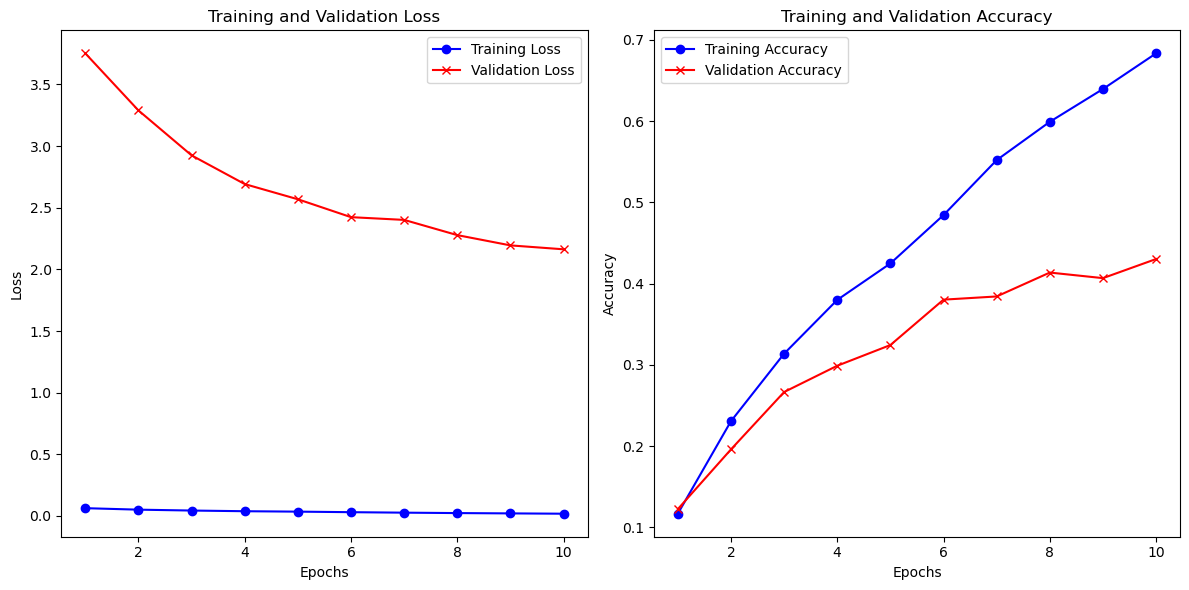

In [13]:
# Визуализация потерь
plt.figure(figsize=(12, 6))

# Потери
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss', color='blue', marker='o')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss', color='red', marker='x')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Точность
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), train_accuracies, label='Training Accuracy', color='blue', marker='o')
plt.plot(range(1, num_epochs + 1), val_accuracies, label='Validation Accuracy', color='red', marker='x')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Отображаем графики
plt.tight_layout()
plt.show()

In [2]:
transform = transforms.Compose([
    transforms.Resize(256),  # Изменим размер изображения так, чтобы его наименьшая сторона была 256
    transforms.CenterCrop(224),  # Обрежем центральную часть до размера 224x224
    transforms.ToTensor(),  # Преобразуем изображение в тензор
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Нормализуем по значениям ImageNet
])

In [4]:
# Загружаем датасет Flowers102
train_dataset = datasets.Flowers102(root='data', split='train', transform=transform, download=True)
valid_dataset = datasets.Flowers102(root='data', split='val', transform=transform, download=True)

# Создаем загрузчики данных для батчей
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False, num_workers=4)

In [5]:
len(train_dataset), len(valid_dataset)

(1020, 1020)

In [6]:
from torchvision import models

model = models.resnet50(pretrained = True)

E:\anaconda\envs\myenv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
E:\anaconda\envs\myenv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [7]:
for param in model.parameters():
    param.requires_grad = False

model.fc = torch.nn.Linear(model.fc.in_features, 102)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [8]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(),lr=0.001)

In [9]:
from tqdm import tqdm

def train(model, train_loader, valid_loader, criterion, optimizer, num_epochs=10):
    for epoch in range(num_epochs):
        model.train()  # Включаем режим обучения
        running_loss = 0.0
        correct = 0
        total = 0

        # Цикл обучения
        for inputs, labels in tqdm(train_loader, desc=f"Эпоха {epoch + 1}/{num_epochs}", leave=False):
            inputs, labels = inputs.to(device), labels.to(device)

            # Обнуляем градиенты
            optimizer.zero_grad()

            # Прямой проход
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Обратный проход и обновление весов
            loss.backward()
            optimizer.step()

            # Считаем статистику
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        # Выводим статистику после каждой эпохи
        epoch_loss = running_loss / len(train_loader)
        epoch_accuracy = 100 * correct / total
        print(f"Эпоха {epoch+1}/{num_epochs}, Потери: {epoch_loss:.4f}, Точность: {epoch_accuracy:.2f}%")

        # Валидация после каждой эпохи
        model.eval()  # Включаем режим оценки
        with torch.no_grad():
            val_correct = 0
            val_total = 0
            for inputs, labels in valid_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                _, predicted = torch.max(outputs, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

            val_accuracy = 100 * val_correct / val_total
            print(f"Точность на валидации: {val_accuracy:.2f}%")

train(model, train_loader, valid_loader, criterion, optimizer, num_epochs=10)

Эпоха 1/10, Потери: 4.4921, Точность: 9.41%
Точность на валидации: 31.86%


Эпоха 2/10, Потери: 2.4898, Точность: 61.37%
Точность на валидации: 65.78%


Эпоха 3/10, Потери: 1.4270, Точность: 85.49%
Точность на валидации: 72.65%


Эпоха 4/10, Потери: 0.8889, Точность: 91.96%
Точность на валидации: 80.20%


Эпоха 5/10, Потери: 0.5937, Точность: 96.76%
Точность на валидации: 80.20%


Эпоха 6/10, Потери: 0.4068, Точность: 98.82%
Точность на валидации: 85.10%


Эпоха 7/10, Потери: 0.3050, Точность: 99.51%


Точность на валидации: 85.20%


Эпоха 8/10, Потери: 0.2364, Точность: 99.71%
Точность на валидации: 85.10%


Эпоха 9/10, Потери: 0.1944, Точность: 99.90%
Точность на валидации: 85.49%


Эпоха 10/10, Потери: 0.1597, Точность: 99.80%
Точность на валидации: 86.08%


In [39]:
def evaluate(model, valid_loader):
    model.eval()  # Режим оценки
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in valid_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f"Итоговая точность на валидации: {accuracy:.2f}%")

evaluate(model, valid_loader)

Итоговая точность на валидации: 75.49%
